# Import Section

In [1]:
# For inline plotting with vector graphics
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Color maps for color-blind friendly visualizations
from tol_colors import tol_cmap, tol_cset

# Standard data handling and numerical libraries
import pandas as pd
import numpy as np
import re
import os
import pickle

# Plotting library
import matplotlib.pyplot as plt

# Statistical functions and distributions
from scipy.stats import norm, chi2

# Scikit-learn metrics and calibration curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc

In [2]:
# Define the folder name
folder_name = "figures"

# Check if the folder exists; if not, create it
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'figures' created.


# Data Loading

In [3]:
# load threshold values
threshold_values = pd.read_csv('model_training/kappa_curve_values.csv')

# load predictions and ground truth
data = np.load('model_evaluation/predictions.npz')
y_pred = data['y_pred']
y_pred_proba = data['y_pred_proba']
y_test = data['y_test']

# Load the dictionary from the .pkl file
with open('model_training/cross_validation_results.pkl', 'rb') as f:
    cv_results_dict = pickle.load(f)

# Extract the list of AUCs of the cross-validation results
aucs = cv_results_dict.get("AUCs", [])

In [4]:
# pyFUME might generate probalities outside the [0,1] range
# these cannot be handled by the calibration_curve

def clip_probabilities(y_pred_proba):
    """
    Clips predicted probabilities to ensure they fall within [0,1].
    Values > 1 are set to 1, values < 0 are set to 0.
    
    Args:
        y_pred_proba (numpy.ndarray): Array of predicted probabilities
        
    Returns:
        numpy.ndarray: Clipped probabilities within [0,1] range
    """
    return np.clip(y_pred_proba, 0, 1)

# Use the function on your predictions
y_pred_proba = clip_probabilities(y_pred_proba)

# Tune Decision Threshold

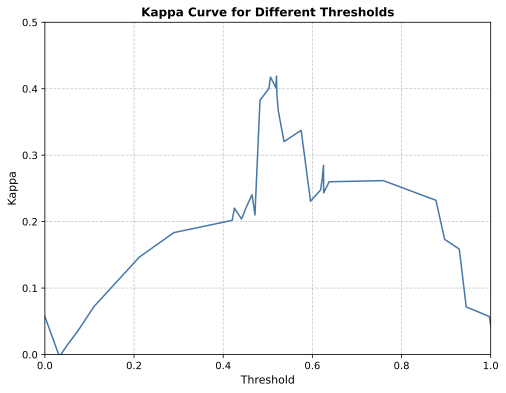

In [5]:
# Set up the figure with APA-style formatting
plt.figure(figsize=(8, 6))

# Plot with tol_cset 'bright' color scheme
cmap = tol_cset('bright')  # Color set for color-blind friendly colors
plt.plot(threshold_values['Threshold'], threshold_values['Kappa'], color=cmap[0])

# Set title and labels
plt.title('Kappa Curve for Different Thresholds', fontsize=12, fontweight='bold')
plt.xlabel('Threshold', fontsize=11)
plt.ylabel('Kappa', fontsize=11)

# Fix x-axis range from 0 to 1
plt.xlim(0, 1)

# Fix y-axis range from 0 to 0.5
plt.ylim(0, 0.5)

# grid and display
plt.grid(True, linestyle='--', alpha=0.7)
# save kappa curve
plt.savefig('figures/kappa_curve_different_thresholds.pdf', format='pdf')
# display kappa curve
plt.show()

# Cross Validation

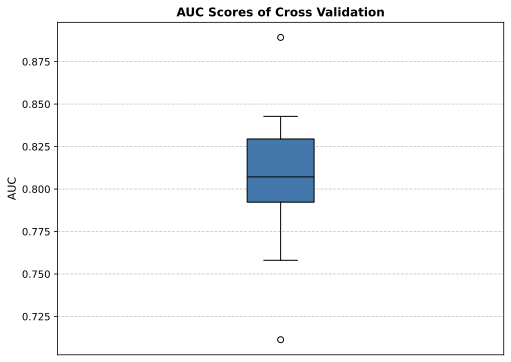

In [6]:
# AUC values for cross validation
auc_values = aucs

# Set up the figure with APA-style formatting
plt.figure(figsize=(8, 6))

# Define the color-blind friendly color scheme
cmap = tol_cset('bright')

# Create the box plot using the color-blind-friendly color
plt.boxplot(auc_values, patch_artist=True, boxprops=dict(facecolor=cmap[0], color='black'), 
            medianprops=dict(color='black'))

# Set title and labels
plt.title('AUC Scores of Cross Validation', fontsize=12, fontweight='bold')
# Remove x-axis tick labels
plt.xticks([])
plt.ylabel('AUC', fontsize=11)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Save and display the plot
plt.savefig('figures/AUC_scores_cross_validation.pdf', format='pdf')
plt.show()

# Final Model - Membership Functions

In [7]:
def extract_membership_functions(file_content):
    # Regular expressions for various membership functions
    function_patterns = {
        'Gaussian_MF': re.compile(r'Gaussian_MF\(([-0-9.,\s]+)\)'),
        'DoubleGaussian_MF': re.compile(r'DoubleGaussian_MF\(([-0-9.,\s]+)\)'),
        'Sigmoid_MF': re.compile(r'Sigmoid_MF\(([-0-9.,\s]+)\)'),
        'InvGaussian_MF': re.compile(r'InvGaussian_MF\(([-0-9.,\s]+)\)'),
        'Singletons_MF': re.compile(r'Singletons_MF\(([-0-9.,\s]+)\)'),
        'Triangular_MF': re.compile(r'Triangular_MF\(([-0-9.,\s]+)\)'),
        'Trapezoidal_MF': re.compile(r'Trapezoidal_MF\(([-0-9.,\s]+)\)'),
        'InvSigmoid_MF': re.compile(r'InvSigmoid_MF\(([-0-9.,\s]+)\)'),
        'Crisp_MF': re.compile(r'Crisp_MF\(([-0-9.,\s]+)\)'),
    }

    # Regular expression for extracting the concept/linguistic variable
    concept_pattern = re.compile(r"concept='([\w\d_]+)'")

    # Initialize storage for results
    membership_functions = []

    # Split file content into lines
    lines = file_content.splitlines()

    # Temporary storage for membership functions and concepts
    current_functions = []
    current_concept = None

    # Parse lines in reverse to ensure correct mapping between functions and concepts
    for i in range(len(lines) - 1, -1, -1):
        line = lines[i]

        # Check for concept definition
        concept_match = concept_pattern.search(line)
        if concept_match:
            if current_functions:
                membership_functions.append({
                    'concept': current_concept,
                    'functions': current_functions[::-1]  # Reverse to maintain correct order
                })
            current_concept = concept_match.group(1)
            current_functions = []
        
        # Check for membership function definitions
        for ftype, pattern in function_patterns.items():
            match = pattern.search(line)
            if match:
                params = list(map(float, match.group(1).split(',')))  # Convert to floats
                current_functions.append({'type': ftype, 'parameters': params})

    # Capture the last concept and its functions
    if current_concept and current_functions:
        membership_functions.append({
            'concept': current_concept,
            'functions': current_functions[::-1]
        })

    # Reverse the final list since parsing was done in reverse order
    return membership_functions[::-1]

In [8]:
# Function to load the content of Simpful_code.py
def load_file(file_path):
    try:
        with open(file_path, 'r') as file:
            return file.read()  # Read the entire content of the file
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

# File path
file_path = 'model_training/Simpful_code.py'  # Update this path if needed

# Call the function and display results
file_content = load_file(file_path)

# Callfunction to extract membership functions
results = extract_membership_functions(file_content)

# Convert the results to a DataFrame for display in the Jupyter Notebook
MF_data = pd.json_normalize(results, 'functions', ['concept'])
MF_data.head()

,type,parameters,concept
0,Trapezoidal_MF,"[-0.002094, -0.001118, 0.001739, 0.0032]",p728_i0_Category_B
1,Trapezoidal_MF,"[-0.001965, -0.001965, 0.001882, 0.001883]",p728_i0_Category_B
2,Trapezoidal_MF,"[-0.002559, -0.002559, 0.003073, 0.003074]",p728_i0_Category_B
3,Trapezoidal_MF,"[-0.002094, -0.002094, 0.001895, 0.001896]",p728_i0_Category_B
4,Trapezoidal_MF,"[0.998258, 0.998258, 1.001243, 1.001244]",p728_i0_Category_B


In [9]:
def plot_membership_degree(MF_data, concept_name):
    # Filter the DataFrame for the selected concept
    concept_data = MF_data[MF_data['concept'] == concept_name]

    # If no data for the concept, exit
    if concept_data.empty:
        print(f"No data found for concept: {concept_name}")
        return

    def sigmoid(x, a, b):
        z = a * (x - b)
        # Avoid overflow using conditions on z
        with np.errstate(over='ignore'):
            return np.where(
                z >= 0,
                1 / (1 + np.exp(-z)),  # Safe for z >= 0
                1 - 1 / (1 + np.exp(z))  # Safe for z < 0
            )

    plt.figure(figsize=(8, 6))

    # Iterate over the rows for the concept
    for cluster, row in enumerate(concept_data.iterrows(), start=1):
        _, row_data = row
        func_type = row_data['type']
        params = row_data['parameters']

        # Generate membership degrees based on function type
        if func_type == 'Gaussian_MF':
            mean, stddev = params
            x = np.linspace(mean - 3*stddev, mean + 3*stddev, 1000)
            y = norm.pdf(x, mean, stddev)
        elif func_type == 'Sigmoid_MF':
            a, b = params
            x = np.linspace(-10, 10, 1000)
            y = sigmoid(x, a, b)
        elif func_type == 'DoubleGaussian_MF':
            mean1, stddev1, mean2, stddev2 = params
            x = np.linspace(mean1 - 3*stddev1, mean2 + 3*stddev2, 1000)
            y1 = norm.pdf(x, mean1, stddev1)
            y2 = norm.pdf(x, mean2, stddev2)
            y = y1 + y2
        elif func_type == 'Triangular_MF':
            a, b, c = params
            x = np.linspace(a, c, 1000)
            y = np.maximum(np.minimum((x-a)/(b-a), (c-x)/(c-b)), 0)
        elif func_type == 'Trapezoidal_MF':
            a, b, c, d = params
            x = np.linspace(a, d, 1000)
            y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
        else:
            print(f"Unsupported membership function type: {func_type}")
            continue

        # Plot the membership degree
        plt.plot(x, y, label=f'Cluster {cluster}')

    # Add plot titles and labels
    plt.title(concept_name)
    plt.ylabel('Membership Degree')
    plt.ylim(0, 1)
    plt.legend()

    # Show and save the plot
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f'figures/{concept_name}.pdf', format='pdf')
    plt.show()

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


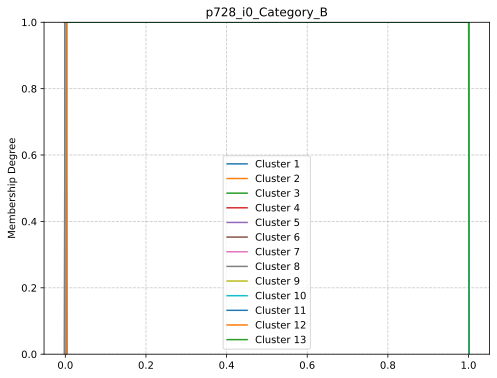

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


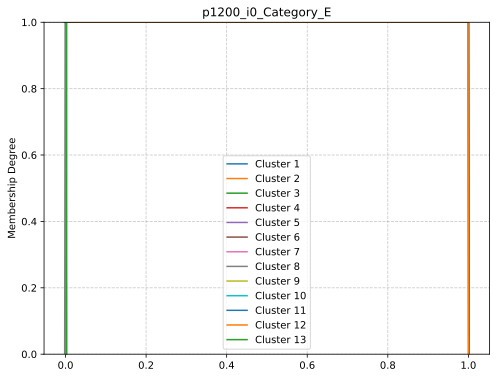

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


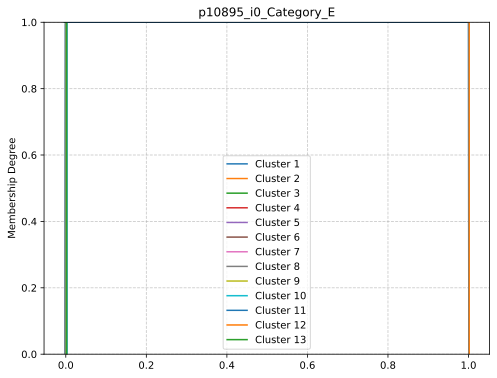

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


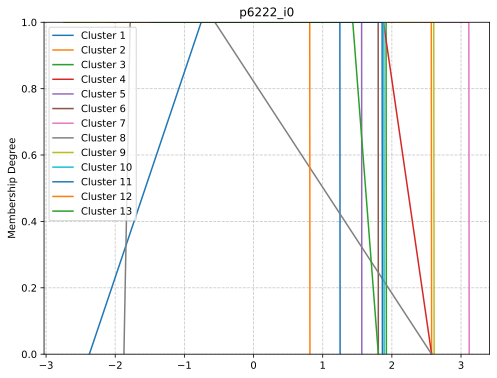

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


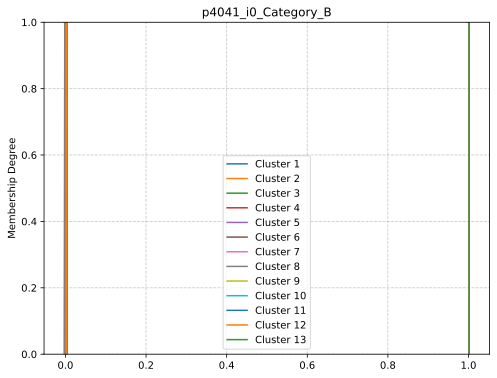

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


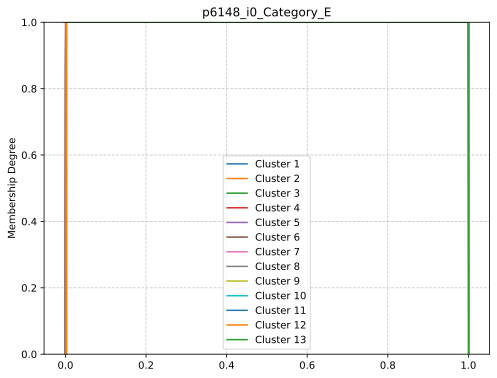

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


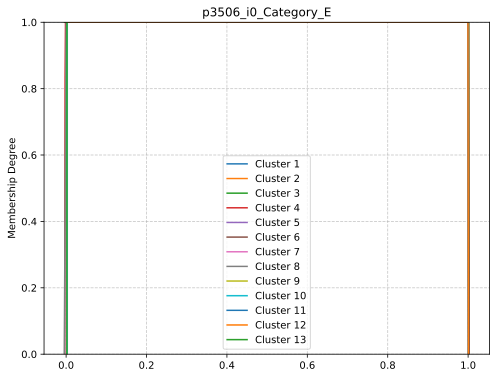

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


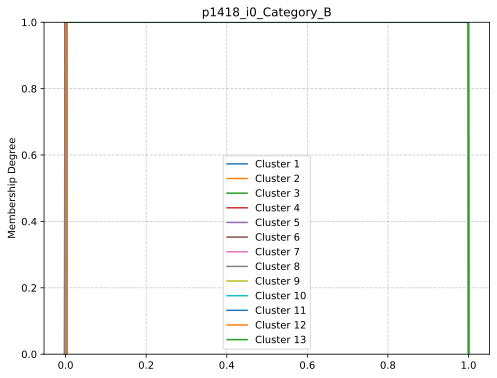

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


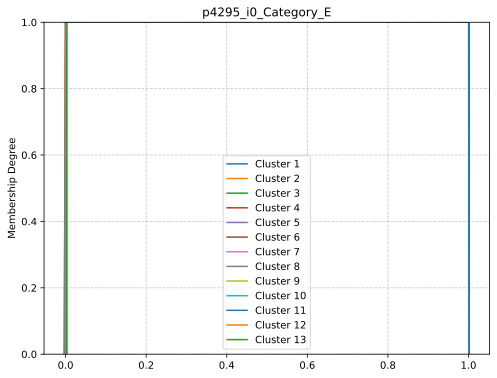

/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: divide by zero encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)
/var/folders/7v/fzfcyzws5qzdpfrmlpvrpykr0000gq/T/ipykernel_31706/1856895883.py:50: RuntimeWarning: invalid value encountered in divide
  y = np.maximum(np.minimum(np.minimum((x-a)/(b-a), 1), (d-x)/(d-c)), 0)


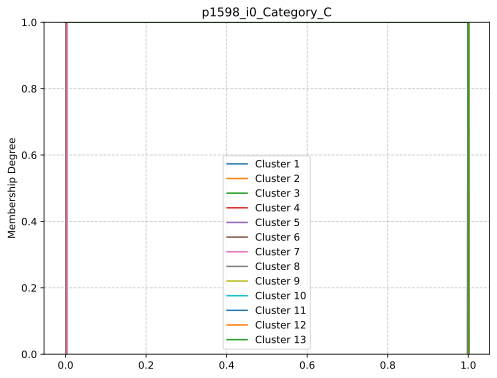

In [10]:
# Plot membership degrees for all features
unique_concepts = MF_data['concept'].unique()  # Get unique concept names
for concept_name in unique_concepts:
    plot_membership_degree(MF_data, concept_name)

# Final Model AUC and AUK curves

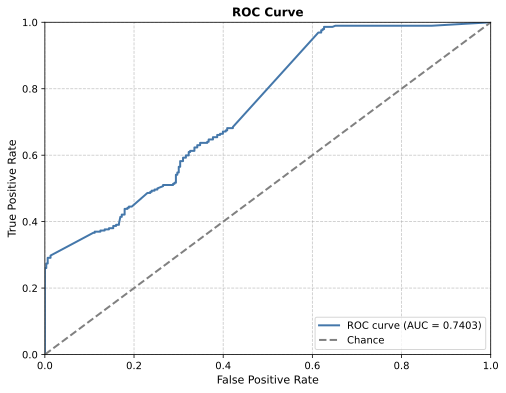

In [11]:
# Compute ROC curve and AUC for y_pred_proba and y_test
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Set up the figure with APA-style formatting
plt.figure(figsize=(8, 6))

# Use tol_bright color scheme
cmap = tol_cset('bright')
plt.plot(fpr, tpr, color=cmap[0], lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')

# Set title and labels
plt.title('ROC Curve', fontsize=12, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)

# Set x-axis and y-axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Enable grid and display legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="lower right")

# Save the ROC curve as a PDF
plt.savefig('figures/roc_curve.pdf', format='pdf')

# Display the ROC curve
plt.show()

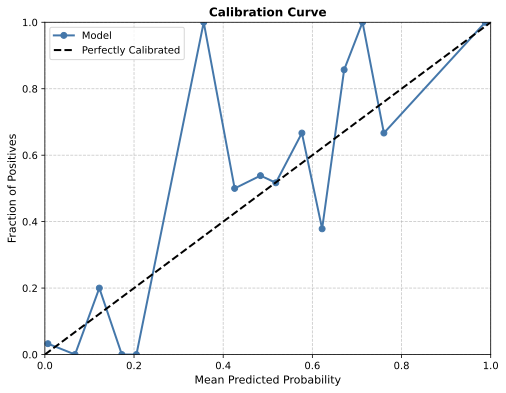

In [12]:
# Calculate the calibration curve (fraction of positives vs. mean predicted probability)
fraction_of_positives, mean_predicted_probabilities = calibration_curve(y_test, y_pred_proba, n_bins=20)

# Set up the figure with APA-style formatting
plt.figure(figsize=(8, 6))

# Use tol_bright color scheme
cmap = tol_cset('bright')

# Plot the calibration curve
plt.plot(mean_predicted_probabilities, fraction_of_positives, marker='o', color=cmap[0], lw=2, label='Model')

# Plot the perfectly calibrated line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfectly Calibrated')

# Set title and labels
plt.title('Calibration Curve', fontsize=12, fontweight='bold')
plt.xlabel('Mean Predicted Probability', fontsize=11)
plt.ylabel('Fraction of Positives', fontsize=11)

# Set x-axis and y-axis limits
plt.xlim([0, 1])
plt.ylim([0, 1])

# Enable grid with APA-style formatting
plt.grid(True, linestyle='--', alpha=0.7)

# Save the calibration curve as a PDF
plt.savefig('figures/calibration_curve.pdf', format='pdf')

# Display the calibration curve
plt.legend()
plt.show()

# Calibration

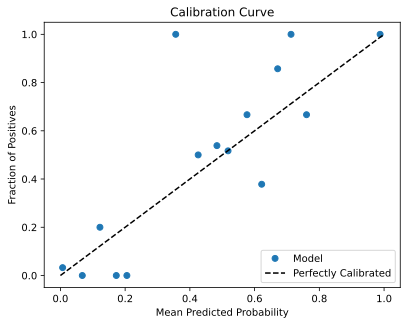

In [13]:
# Calculate the calibration curve (fraction of positives vs. mean predicted probability)
fraction_of_positives, mean_predicted_probabilities = calibration_curve(y_test, y_pred_proba, n_bins=20)

# Plot the calibration curve
plt.plot(mean_predicted_probabilities, fraction_of_positives, marker='o', linestyle='', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [14]:
def hosmer_lemeshow_test(y_true, y_pred_proba, n_bins=10):
    # Step 1: Bin predicted probabilities into n_bins equal-sized bins
    data = np.vstack([y_pred_proba, y_true]).T
    data = data[np.argsort(data[:, 0])]  # Sort by predicted probabilities
    bin_size = len(y_true) // n_bins
    bins = [data[i * bin_size:(i + 1) * bin_size] for i in range(n_bins)]

    # Step 2: Calculate observed and expected frequencies for each bin
    observed_counts = np.array([np.sum(bin[:, 1]) for bin in bins])
    expected_counts = np.array([np.sum(bin[:, 0]) for bin in bins])

    # Step 3: Calculate Hosmer-Lemeshow statistic
    hl_statistic = np.sum((observed_counts - expected_counts) ** 2 / (expected_counts * (1 - expected_counts / bin_size)))

    # Step 4: Calculate p-value using chi-squared distribution with (n_bins - 2) degrees of freedom
    p_value = 1 - chi2.cdf(hl_statistic, n_bins - 2)

    return hl_statistic, p_value

# calcualte Hosmer Lemeshow test
hl_statistic, p_value = hosmer_lemeshow_test(y_test, y_pred_proba)
print(f"Hosmer-Lemeshow statistic: {hl_statistic}")
print(f"P-value: {p_value}")

Hosmer-Lemeshow statistic: 233.76348401407776
P-value: 0.0


# create figure for pipeline

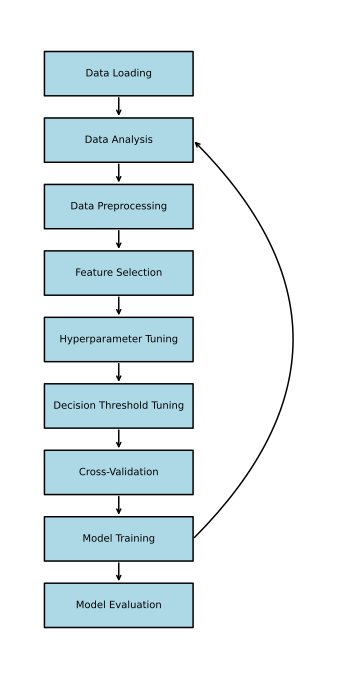

The pipeline diagram with right loop has been saved as: figures/pipeline.pdf


In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 12))
ax.axis("off")

# Helper function to draw a box
def draw_box(ax, text, x, y, width=4, height=1, color="#ADD8E6"):
    rect = mpatches.Rectangle((x - width / 2, y - height / 2), width, height, edgecolor="black", facecolor=color, lw=1.5)
    ax.add_patch(rect)
    ax.text(x, y, text, ha="center", va="center", fontsize=10, color="black")
    return (x, y)

# Labels for the boxes
boxes = [
    "Data Loading", "Data Analysis", "Data Preprocessing", "Feature Selection",
    "Hyperparameter Tuning", "Decision Threshold Tuning",
    "Cross-Validation", "Model Training", "Model Evaluation"
]

# Draw boxes in a vertical line and store their positions
positions = []
for i, label in enumerate(boxes):
    y = -i * 1.5  # Fixed vertical spacing
    positions.append(draw_box(ax, label, 0, y))

# Add arrows between the boxes
for i in range(len(positions) - 1):
    x_start, y_start = positions[i]
    x_end, y_end = positions[i + 1]
    ax.annotate("", xy=(x_end, y_end + 0.5), xytext=(x_start, y_start - 0.5),
                arrowprops=dict(arrowstyle="->", color="black", lw=1.5))

# Add loop-back arrow from "Model Training" to "Data Analysis"
x_start, y_start = positions[-2]  # "Model Training"
x_end, y_end = positions[1]  # "Data Analysis"
loop_x_offset = 2  # Move the loop further to the right
ax.annotate("", xy=(x_end + loop_x_offset, y_end), xytext=(x_start + loop_x_offset, y_start),
            arrowprops=dict(arrowstyle="->", color="black", lw=1.5,
                            connectionstyle="arc3,rad=0.5"))  # Curved arrow bent to the right

# Set axis limits to ensure visibility
ax.set_xlim(-3, 6)
ax.set_ylim(-len(boxes) * 1.5, 1.5)

# Save and show the plot
output_path = "figures/pipeline.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

print(f"The pipeline diagram with right loop has been saved as: {output_path}")